In [2]:
import requests
import pandas as pd
import spacy
from textstat import textstat
import re
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch


C:\Users\david\anaconda3\envs\wiki\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
nlp = spacy.load("en_core_web_sm")


In [4]:
print(torch.__version__)
print(torch.version.cuda)  # Should not be None
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

2.7.1+cu118
11.8
True
1
NVIDIA GeForce RTX 2070 with Max-Q Design


In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
if torch.cuda.is_available():
    print("cuda available!")
    model.to("cuda")
else:
    print('cuda not available!')


cuda available!


In [6]:
sample_pages = [
    "Python (programming language)",
    "Machine learning",
    "Artificial intelligence"
]


In [7]:
START_TIMESTAMP = "2022-10-01T00:00:00Z"
END_TIMESTAMP   = "2023-10-31T23:59:59Z"


In [8]:
columns = [
    "page_title", "rev_id", "timestamp", "user", "is_bot", "content"
]
tiny_revs = pd.DataFrame(columns=columns)


In [9]:
def is_bot_username(username: str) -> bool:
    return username.lower().endswith("bot")


In [10]:
import requests
import pandas as pd
from dateutil import parser

def fetch_revision_snapshots(
    title: str,
    start_ts: str,
    end_ts: str,
    freq: str = "7D",
    bot_test_fn: callable = None,
) -> pd.DataFrame:
    """
    Fetches all revisions for `title` between start_ts and end_ts (inclusive),
    then returns a DataFrame of snapshots at the given frequency.

    Args:
      title      : Wikipedia page title
      start_ts   : ISO8601 timestamp string, e.g. "2020-01-01T00:00:00Z"
      end_ts     : ISO8601 timestamp string, e.g. "2024-12-31T23:59:59Z"
      freq       : pandas offset alias for sampling, e.g. "7D" (7 days),
                   "W-MON" (weekly on Mondays), "1M" (monthly), etc.
      bot_test_fn: optional fn(username)->bool to flag bots. If None,
                   no bot flag is set.

    Returns:
      DataFrame with columns
        ['page_title', 'snapshot_ts', 'rev_id', 'timestamp', 'user', 'is_bot', 'content']
      where `snapshot_ts` is each sample point, and the row is the latest
      revision at or before that time.
    """
    # 1) Fetch all revisions via the API
    S, URL = requests.Session(), "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "rvprop": "ids|timestamp|user|comment|content",
        "rvstart": end_ts,
        "rvend": start_ts,
        "rvlimit": "max",
        "titles": title,
        "redirects": 1,
        "rvslots": "main",
    }
    all_revs = []
    while True:
        resp = S.get(URL, params=params).json()
        pages = resp["query"]["pages"]
        pid = next(iter(pages))
        if "revisions" not in pages[pid]:
            break
        for rev in pages[pid]["revisions"]:
            ts = rev["timestamp"]
            all_revs.append({
                "rev_id": rev["revid"],
                "timestamp": parser.isoparse(ts),
                "user": rev["user"],
                "is_bot": bot_test_fn(rev["user"]) if bot_test_fn else False,
                "content": rev.get("slots", {}).get("main", {}).get("*", "")
            })
        if "continue" in resp:
            params.update(resp["continue"])
        else:
            break

    # 2) Build a DataFrame and sort by timestamp
    df = pd.DataFrame(all_revs)
    if df.empty:
        return pd.DataFrame()  # no revisions in interval
    df = df.sort_values("timestamp").reset_index(drop=True)

    # 3) Create a list of sample timestamps
    #    We interpret start_ts/end_ts as inclusive bounds:
    sample_times = pd.date_range(
        start=parser.isoparse(start_ts),
        end=parser.isoparse(end_ts),
        freq=freq
    )

    # 4) For each sample time, pick the last revision <= that time
    snapshots = []
    idx = 0  # pointer into df rows
    for snap_t in sample_times:
        # advance idx until df.timestamp[idx] > snap_t
        while idx < len(df) and df.loc[idx, "timestamp"] <= snap_t:
            idx += 1
        # the snapshot is the revision just before that (idx-1), if any
        if idx > 0:
            row = df.loc[idx - 1].copy()
            row["page_title"]  = title
            row["snapshot_ts"] = snap_t
            snapshots.append(row)
        else:
            # no revision yet at this snapshot time → skip or carry forward?
            # if you want carry-forward from previous page start, you might:
            # continue
            pass

    # 5) Return snapshots as a DataFrame
    snap_df = pd.DataFrame(snapshots)
    # reorder columns
    cols = ["page_title", "snapshot_ts", "rev_id", "timestamp", "user", "is_bot", "content"]
    return snap_df[cols]


In [12]:
rows = []
for pg in sample_pages:
    revs = fetch_revision_snapshots(
        pg, START_TIMESTAMP, END_TIMESTAMP,
        freq="7D", bot_test_fn=is_bot_username
    )
    # Convert DataFrame rows to dictionaries
    for _, r in revs.iterrows():
        rows.append({
            "page_title": pg,
            "rev_id": r["rev_id"],
            "timestamp": r["timestamp"],
            "user": r["user"],
            "is_bot": r["is_bot"],
            "content": r["content"]
        })

tiny_revs = pd.DataFrame(rows)

In [14]:
tiny_revs.head(120)
# tiny_revs.shape


,page_title,rev_id,timestamp,user,is_bot,content
0,Python (programming language),1114609534,2022-10-07 10:49:15+00:00,Wikipedialuva,False,{{Short description|General-purpose programmin...
1,Python (programming language),1115795931,2022-10-13 07:16:45+00:00,Peaceray,False,{{Short description|General-purpose programmin...
2,Python (programming language),1117191839,2022-10-20 11:38:45+00:00,Fbergo,False,{{Short description|General-purpose programmin...
3,Python (programming language),1118403860,2022-10-26 20:50:13+00:00,MrOllie,False,{{Short description|General-purpose programmin...
4,Python (programming language),1119573205,2022-11-02 08:20:13+00:00,Gadfium,False,{{Short description|General-purpose programmin...
...,...,...,...,...,...,...
115,Artificial intelligence,1118739702,2022-10-28 16:08:20+00:00,MrOllie,False,{{Short description|Intelligence demonstrated ...
116,Artificial intelligence,1119875435,2022-11-03 22:02:01+00:00,Veritas Aeterna,False,{{Short description|Intelligence demonstrated ...
117,Artificial intelligence,1120996293,2022-11-09 23:39:52+00:00,Maxeto0910,False,{{Short description|Intelligence demonstrated ...
118,Artificial intelligence,1122659805,2022-11-18 21:01:20+00:00,LEvalyn,False,{{Short description|The ability of systems to ...


In [39]:
tiny_revs.to_pickle("tiny_revisions.pkl")


---
# 4 Text Cleaning & Sentence/Token Parsing



In [15]:
def clean_text(wikitext: str) -> str:
    # Remove wiki markup—keep plain text for prototype
    text = re.sub(r"<ref>.*?</ref>", "", wikitext, flags=re.DOTALL)
    text = re.sub(r"\{\{.*?\}\}", "", text)             # simple template removal
    text = re.sub(r"\[\[([^|\]]*\|)?([^\]]+)\]\]", r"\2", text)  # keep link text
    text = re.sub(r"''+", "", text)                     # remove italic/bold
    # Remove non-alphabetic chars except basic punctuation
    text = re.sub(r"[^A-Za-z0-9 \.\,\!\?\-\'\"]+", " ", text)
    # Lowercase and collapse whitespace
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [16]:
tiny_revs["plain_text"] = tiny_revs["content"].apply(clean_text)


In [17]:
def parse_with_spacy(text: str):
    doc = nlp(text)
    total_tokens = len(doc)

    # POS proportions
    pos_counts = doc.count_by(spacy.attrs.POS)
    upos_props = {nlp.vocab[pos].text: cnt / total_tokens for pos, cnt in pos_counts.items()}

    # Dependency depth approximation
    def token_depth(token):
        depth = 0
        while token != token.head:
            token = token.head
            depth += 1
        return depth
    depths = [token_depth(token) for token in doc]
    mean_depth = sum(depths) / total_tokens if total_tokens else 0

    # Clause ratio
    clause_tags = sum(1 for token in doc if token.dep_ in ("advcl", "ccomp", "xcomp"))
    clause_ratio = clause_tags / (len(list(doc.sents)) or 1)

    # Passive voice ratio
    passive_count = sum(1 for token in doc if token.dep_ == "auxpass")
    voice_ratio = (total_tokens - passive_count) / (total_tokens or 1)

    return {
        "upos_props": upos_props,
        "mean_dep_depth": mean_depth,
        "clause_ratio": clause_ratio,
        "voice_ratio": voice_ratio,
        "sentences": [sent.text for sent in doc.sents],  # Convert Span to text
        "tokens": [token.text for token in doc]
    }

In [18]:
sample_parsed = tiny_revs["plain_text"].iloc[:10].apply(parse_with_spacy)
sample_parsed[0]


{'upos_props': {'NOUN': 0.2907051282051282,
  'PROPN': 0.08408119658119659,
  'X': 0.002457264957264957,
  'PUNCT': 0.16100427350427352,
  'VERB': 0.08611111111111111,
  'ADJ': 0.07478632478632478,
  'SCONJ': 0.008974358974358974,
  'NUM': 0.02232905982905983,
  'CCONJ': 0.029166666666666667,
  'ADP': 0.08333333333333333,
  'DET': 0.05576923076923077,
  'AUX': 0.03717948717948718,
  'PART': 0.015277777777777777,
  'PRON': 0.021688034188034187,
  'ADV': 0.026495726495726495,
  'INTJ': 0.000641025641025641},
 'mean_dep_depth': 4.593803418803419,
 'clause_ratio': 0.7096774193548387,
 'voice_ratio': 0.9846153846153847,
 'sentences': ['infobox programming language logo python-logo-notext.svg logo size 121px paradigm multi-paradigm object-oriented, procedural imperative , functional, structured, reflective released ref name "alt-sources-history" ref designer guido van rossum developer python software foundation latest release version latest release date latest preview version latest preview 

In [19]:
# put it back into tiny_revs, add a progress bar 
from tqdm.auto import tqdm
tqdm.pandas(desc="Parsing with spaCy")
# Apply the parsing function to the 'plain_text' column with progress tracking
tiny_revs["parsed"] = tiny_revs["plain_text"].progress_apply(parse_with_spacy)

Parsing with spaCy:   0%|          | 0/168 [00:00<?, ?it/s]

In [20]:
sample_parsed.head()

0    {'upos_props': {'NOUN': 0.2907051282051282, 'P...
1    {'upos_props': {'NOUN': 0.2907051282051282, 'P...
2    {'upos_props': {'NOUN': 0.2905355051634196, 'P...
3    {'upos_props': {'NOUN': 0.2905355051634196, 'P...
4    {'upos_props': {'NOUN': 0.29069767441860467, '...
Name: plain_text, dtype: object

In [21]:
# check tiny_revs
tiny_revs.head(20)

,page_title,rev_id,timestamp,user,is_bot,content,plain_text,parsed
0,Python (programming language),1114609534,2022-10-07 10:49:15+00:00,Wikipedialuva,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2907051282051282, 'P..."
1,Python (programming language),1115795931,2022-10-13 07:16:45+00:00,Peaceray,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2907051282051282, 'P..."
2,Python (programming language),1117191839,2022-10-20 11:38:45+00:00,Fbergo,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2905355051634196, 'P..."
3,Python (programming language),1118403860,2022-10-26 20:50:13+00:00,MrOllie,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2905355051634196, 'P..."
4,Python (programming language),1119573205,2022-11-02 08:20:13+00:00,Gadfium,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.29069767441860467, '..."
5,Python (programming language),1121215076,2022-11-11 03:34:39+00:00,Discospinster,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.29091869060190073, '..."
6,Python (programming language),1122594713,2022-11-18 11:42:36+00:00,Timothytyy,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2906854499579479, 'P..."
7,Python (programming language),1123726092,2022-11-25 09:41:27+00:00,Jumbo T,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2929357021996616, 'P..."
8,Python (programming language),1124941195,2022-12-01 09:56:32+00:00,Wikipedialuva,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2929357021996616, 'P..."
9,Python (programming language),1126246825,2022-12-08 09:00:12+00:00,MusikBot II,False,{{pp|small=yes}}\n{{Short description|General-...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2929357021996616, 'P..."


In [56]:
# write to pickle
tiny_revs.to_pickle("tiny_revisions_parsed.pkl")

In [5]:
# read from pickle
tiny_revs = pd.read_pickle("tiny_revisions_parsed.pkl")

---
# 5 Feature Extraction Functions


In [22]:
tiny_trigger = {"delves", "pivotal", "showcasing", "leverage", "optimize"}

def compute_delta(text: str, trigger_set: set, baseline_freq: float = 0.0001):
    tokens = text.split()
    if not tokens:
        return 0.0
    freq = sum(1 for t in tokens if t in trigger_set) / len(tokens)
    return freq - baseline_freq


In [23]:
# add delta column to tiny_revs
tiny_revs["delta"] = tiny_revs["plain_text"].apply(lambda txt: compute_delta(txt, tiny_trigger))

In [24]:

def compute_perplexity_and_burstiness(text: str, max_length: int = 512):
    """
    GPU-optimized perplexity calculation with input validation for GPT-2
    """
    if not text or len(text.strip()) == 0:
        return 0.0, 0.0

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if not torch.cuda.is_available():
        print("WARNING: CUDA not available!")
        return 0.0, 0.0

    if model.device.type != "cuda":
        model.to("cuda")

    try:
        encodings = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length
        )
        input_ids = encodings.input_ids

        # Clamp input_ids to valid range
        vocab_size = model.config.vocab_size
        if torch.any(input_ids >= vocab_size) or torch.any(input_ids < 0):
            input_ids = torch.clamp(input_ids, 0, vocab_size - 1)

        if input_ids.shape[1] < 5:
            return 0.0, 0.0

        input_ids = input_ids.to("cuda")

        chunk_size = 8
        total_loss = 0.0
        total_tokens = 0

        for i in range(0, input_ids.shape[1], chunk_size):
            end_idx = min(i + chunk_size, input_ids.shape[1])
            chunk = input_ids[:, i:end_idx]
            try:
                with torch.no_grad():
                    outputs = model(chunk, labels=chunk)
                chunk_loss = outputs.loss.item() * chunk.shape[1]
                total_loss += chunk_loss
                total_tokens += chunk.shape[1]
            except Exception as e:
                print(f"Skipping chunk {i}:{end_idx} due to error: {str(e)}")
                continue

        if total_tokens == 0:
            return 0.0, 0.0

        avg_loss = total_loss / total_tokens
        ppl = torch.exp(torch.tensor(avg_loss)).item()

        log_probs = []
        positions = [min(10, input_ids.shape[1]-1), min(20, input_ids.shape[1]-1)]
        for pos in positions:
            if pos < 5:
                continue
            try:
                segment = input_ids[:, :pos]
                with torch.no_grad():
                    out = model(segment, labels=segment)
                log_probs.append(-out.loss.item())
            except Exception:
                continue

        burstiness = float(pd.Series(log_probs).std()) if len(log_probs) > 1 else 0.0
        return ppl, burstiness

    except Exception as e:
        print(f"Error: {str(e)[:100]}...")
        return 0.0, 0.0

In [25]:
# Test with a small sample first
small_text = tiny_revs["plain_text"].iloc[2][:10000]  # Just the first 10000 chars
ppl, burst = compute_perplexity_and_burstiness(small_text)
print(f"Perplexity: {ppl}, Burstiness: {burst}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Perplexity: 667.0406494140625, Burstiness: 0.05143129347566185


In [26]:
from tqdm.auto import tqdm

tqdm.pandas(desc="Computing perplexity and burstiness")
# Apply the perplexity and burstiness function to the 'plain_text' column with progress tracking
tiny_revs[["perplexity", "burstiness"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_perplexity_and_burstiness).tolist(),
                 index=tiny_revs.index)


Computing perplexity and burstiness:   0%|          | 0/168 [00:00<?, ?it/s]

In [28]:
# Directly extract attributes from parsed dictionaries
tiny_revs["upos_props"] = tiny_revs["parsed"].apply(lambda x: x["upos_props"])
tiny_revs["mean_dep_depth"] = tiny_revs["parsed"].apply(lambda x: x["mean_dep_depth"])
tiny_revs["clause_ratio"] = tiny_revs["parsed"].apply(lambda x: x["clause_ratio"])
tiny_revs["voice_ratio"] = tiny_revs["parsed"].apply(lambda x: x["voice_ratio"])

In [34]:
tiny_revs.head(200)

,page_title,rev_id,timestamp,user,is_bot,content,plain_text,parsed,delta,perplexity,burstiness,upos_props,mean_dep_depth,clause_ratio,voice_ratio,fre,fog,chars_per_sent,sents_per_para
0,Python (programming language),1114609534,2022-10-07 10:49:15+00:00,Wikipedialuva,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2907051282051282, 'P...",-0.000100,667.040649,0.051431,"{'NOUN': 0.2907051282051282, 'PROPN': 0.084081...",4.593803,0.709677,0.984615,40.620717,15.470734,159.419355,310
1,Python (programming language),1115795931,2022-10-13 07:16:45+00:00,Peaceray,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2907051282051282, 'P...",-0.000100,667.040649,0.051431,"{'NOUN': 0.2907051282051282, 'PROPN': 0.084081...",4.593803,0.709677,0.984615,40.620717,15.470734,159.419355,310
2,Python (programming language),1117191839,2022-10-20 11:38:45+00:00,Fbergo,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2905355051634196, 'P...",-0.000100,667.040649,0.051431,"{'NOUN': 0.2905355051634196, 'PROPN': 0.084531...",4.586820,0.706070,0.984669,40.621798,15.464679,158.367412,313
3,Python (programming language),1118403860,2022-10-26 20:50:13+00:00,MrOllie,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.2905355051634196, 'P...",-0.000100,667.040649,0.051431,"{'NOUN': 0.2905355051634196, 'PROPN': 0.084531...",4.586820,0.706070,0.984669,40.621798,15.464679,158.367412,313
4,Python (programming language),1119573205,2022-11-02 08:20:13+00:00,Gadfium,False,{{Short description|General-purpose programmin...,infobox programming language logo python-logo-...,"{'upos_props': {'NOUN': 0.29069767441860467, '...",-0.000100,667.040649,0.051431,"{'NOUN': 0.29069767441860467, 'PROPN': 0.08424...",4.578118,0.695925,0.984672,40.756672,15.419115,156.579937,319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Artificial intelligence,1177408667,2023-09-27 13:28:42+00:00,MrOllie,False,{{Short description|Intelligence of machines o...,!-- definitions -- artificial intelligence ai ...,"{'upos_props': {'PUNCT': 0.13025232125059014, ...",-0.000036,328.556946,1.516598,"{'PUNCT': 0.13025232125059014, 'NOUN': 0.28799...",3.676179,1.038023,0.991712,33.740884,15.694321,205.804183,526
164,Artificial intelligence,1178806767,2023-10-06 00:49:58+00:00,Krishnachandranvn,False,{{Short description|Intelligence of machines o...,!-- definitions -- artificial intelligence ai ...,"{'upos_props': {'PUNCT': 0.13013842281879195, ...",-0.000037,348.363739,1.516598,"{'PUNCT': 0.13013842281879195, 'NOUN': 0.28806...",3.677800,1.038023,0.991716,33.747160,15.696027,205.916350,526
165,Artificial intelligence,1179416225,2023-10-10 00:20:52+00:00,Citation bot,True,{{Short description|Intelligence of machines o...,!-- definitions -- artificial intelligence ai ...,"{'upos_props': {'PUNCT': 0.13012477718360071, ...",-0.000037,348.363739,1.516598,"{'PUNCT': 0.13012477718360071, 'NOUN': 0.28814...",3.677886,1.038023,0.991716,33.742982,15.695856,205.946768,526
166,Artificial intelligence,1181018059,2023-10-20 09:36:26+00:00,Rodw,False,{{Short description|Intelligence of machines o...,!-- definitions -- artificial intelligence ai ...,"{'upos_props': {'PUNCT': 0.1307120618660239, '...",-0.000100,348.363739,1.516598,"{'PUNCT': 0.1307120618660239, 'NOUN': 0.286532...",3.697801,1.056159,0.991965,33.762889,15.644662,204.784420,552


In [31]:
def compute_readability(text: str):
    fre = textstat.flesch_reading_ease(text)
    fog = textstat.gunning_fog(text)
    # Characters per sentence
    sentences = list(nlp(text).sents)
    chars_per_sent = sum(len(sent.text) for sent in sentences) / (len(sentences) or 1)
    # Sentences per paragraph (since we have flattened text, treat the entire text as one paragraph)
    sents_per_para = len(sentences)  # toy assumption: 1 paragraph = all sentences
    return fre, fog, chars_per_sent, sents_per_para


In [33]:
# add progress bar, this one takes a while
from tqdm import tqdm
tqdm.pandas(desc="Computing readability metrics")
# Apply the readability function to the 'plain_text' column with progress tracking
tiny_revs[["fre", "fog", "chars_per_sent", "sents_per_para"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_readability).tolist(),
                 index=tiny_revs.index)

Computing readability metrics: 100%|██████████| 168/168 [05:11<00:00,  1.85s/it]


In [ ]:
def compute_vocab_diversity(text: str, window_size: int = 250):
    tokens = text.split()[:window_size]
    unique_count = len(set(tokens))
    total_count = len(tokens) or 1
    # Normalized TTR = unique / sqrt(2 * total)
    nTTR = unique_count / ( (2 * total_count) ** 0.5 )
    # Word-density: lines = count of '\n' + 1, avg_line_len:
    lines = text.count("\n") + 1
    avg_line_len = sum(len(line) for line in text.split("\n")) / lines
    wd = 100 * unique_count / (lines * (avg_line_len or 1))
    return nTTR, wd


In [27]:
# add progress bar
from tqdm.auto import tqdm

tqdm.pandas(desc="Computing vocabulary diversity metrics")
# Apply the vocabulary diversity function to the 'plain_text' column with progress tracking
tiny_revs[["nTTR", "word_density"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_vocab_diversity).tolist(),
                 index=tiny_revs.index)

Computing vocabulary diversity metrics:   0%|          | 0/178 [00:00<?, ?it/s]

In [28]:
def compute_line_length(text: str):
    lines = text.split("\n")
    avg_len = sum(len(line) for line in lines) / (len(lines) or 1)
    return avg_len

tiny_revs["avg_line_len"] = tiny_revs["plain_text"].apply(compute_line_length)


In [29]:
def compute_citation_delta(wikitext: str):
    # Count <ref> tags in raw wikitext
    added = len(re.findall(r"<ref[^>]*>", wikitext))
    removed = 0  # For prototype, assume no diff stored; set removed = 0
    tokens_changed = len(wikitext.split()) or 1
    return (added - removed) / tokens_changed

# If you only have full revision text (no diff), set citation_delta = (#ref tags)/tokens
tiny_revs["citation_delta"] = tiny_revs["content"].apply(lambda txt: compute_citation_delta(txt))


In [38]:
features_df = tiny_revs[[
    "page_title", "rev_id", "timestamp", "user", "is_bot",
    "delta", "perplexity", "burstiness",
    "mean_dep_depth", "clause_ratio", "voice_ratio",
    "fre", "fog", "chars_per_sent", "sents_per_para",
    "nTTR", "word_density", "avg_line_len", "citation_delta"
]].copy()



In [39]:
features_df.head(20)

,page_title,rev_id,timestamp,user,is_bot,delta,perplexity,burstiness,mean_dep_depth,clause_ratio,voice_ratio,fre,fog,chars_per_sent,sents_per_para,nTTR,word_density,avg_line_len,citation_delta
0,Python (programming language),1145862507,2023-03-21T11:50:34Z,Comp.arch,False,-0.0001,699.940186,0.051431,4.510000,0.700965,0.985054,40.607090,15.440363,158.180064,311,7.557910,0.341421,49499.0,0.025844
1,Python (programming language),1144434497,2023-03-13T19:11:54Z,Thumperward,False,-0.0001,699.940186,0.051431,4.511773,0.704180,0.985055,40.601759,15.440273,158.212219,311,7.557910,0.341352,49509.0,0.025841
2,Python (programming language),1144432784,2023-03-13T19:00:30Z,Thumperward,False,-0.0001,699.940186,0.051431,4.511773,0.704180,0.985055,40.601759,15.440273,158.212219,311,7.557910,0.341352,49509.0,0.025850
3,Python (programming language),1140647220,2023-02-21T02:12:18Z,Tdmurlock,False,-0.0001,699.940186,0.051431,4.509015,0.708333,0.984975,40.577083,15.449660,158.000000,312,7.557910,0.340712,49602.0,0.025914
4,Python (programming language),1138397948,2023-02-09T13:16:31Z,AirshipJungleman29,False,-0.0001,681.641052,0.051431,4.509768,0.708333,0.984972,40.571269,15.449748,157.967949,312,7.513188,0.338764,49592.0,0.025914
5,Python (programming language),1136880732,2023-02-01T17:08:07Z,Comp.arch,False,-0.0001,681.641052,0.051431,4.509768,0.708333,0.984972,40.571269,15.449748,157.967949,312,7.513188,0.338764,49592.0,0.025910
6,Python (programming language),1136493577,2023-01-30T16:06:17Z,Comp.arch,False,-0.0001,681.641052,0.051431,4.512947,0.713826,0.984958,40.597908,15.439650,158.347267,311,7.513188,0.339045,49551.0,0.025933
7,Python (programming language),1136468201,2023-01-30T13:20:13Z,Jumbo T,False,-0.0001,681.641052,0.051431,4.511650,0.717042,0.984967,40.621163,15.439300,158.401929,311,7.513188,0.338928,49568.0,0.025924
8,Python (programming language),1136459907,2023-01-30T12:13:34Z,Comp.arch,False,-0.0001,681.641052,0.051431,4.512947,0.713826,0.984958,40.609055,15.439650,158.337621,311,7.513188,0.339065,49548.0,0.025933
9,Python (programming language),1136326866,2023-01-29T20:43:04Z,Jumbo T,False,-0.0001,681.641052,0.051431,4.511650,0.717042,0.984967,40.621163,15.439300,158.401929,311,7.513188,0.338928,49568.0,0.025924


In [41]:
# save to pickle
features_df.to_pickle("tiny_revisions_features.pkl")
# save to csv
features_df.to_csv("tiny_revisions_features.csv", index=False)

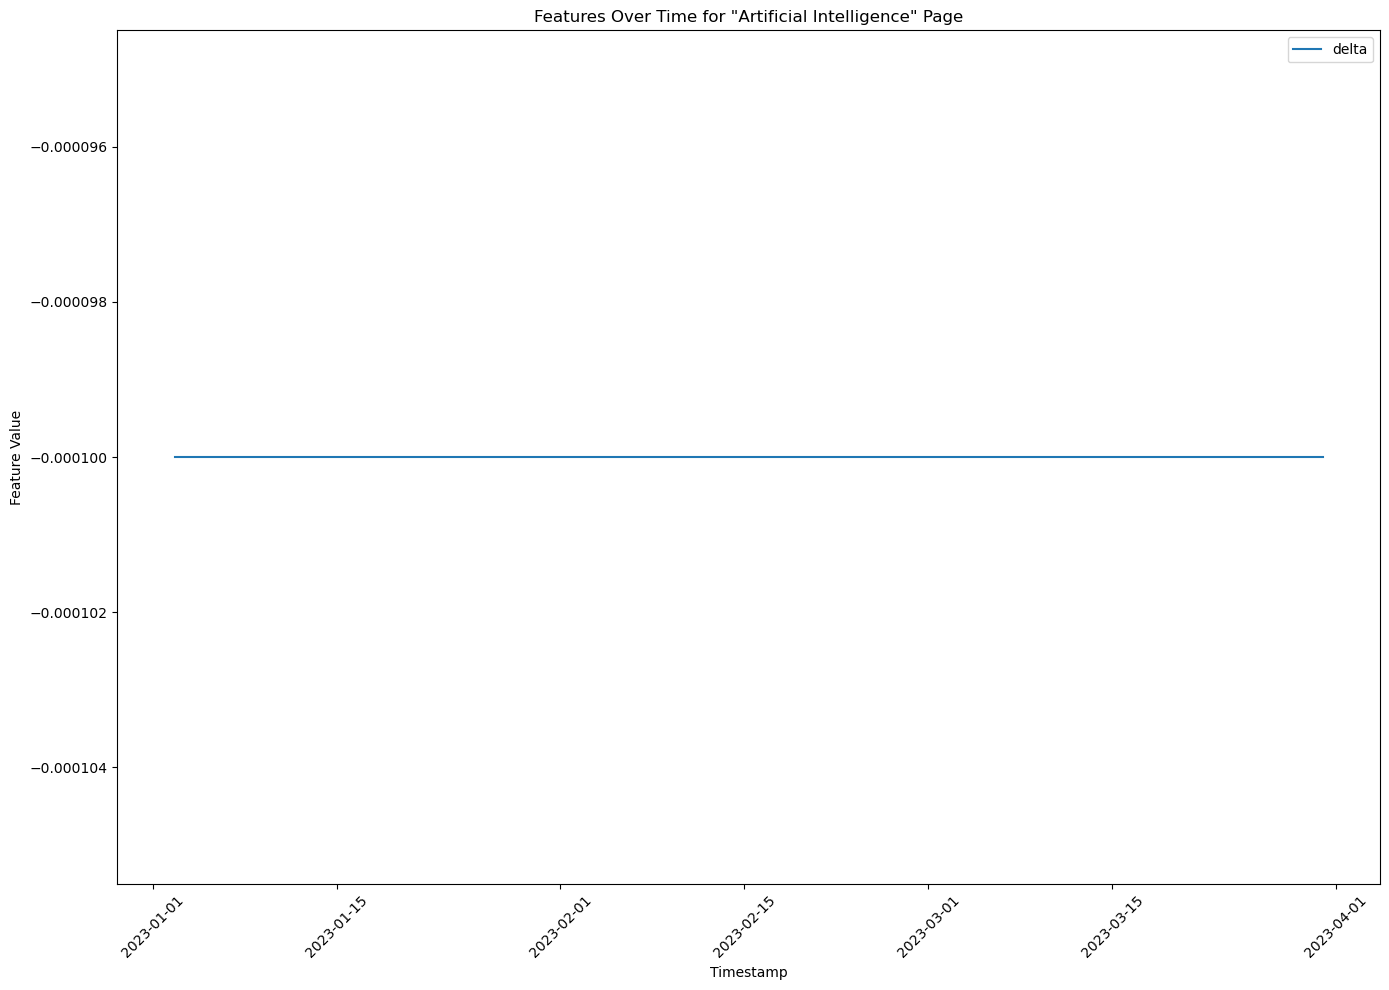

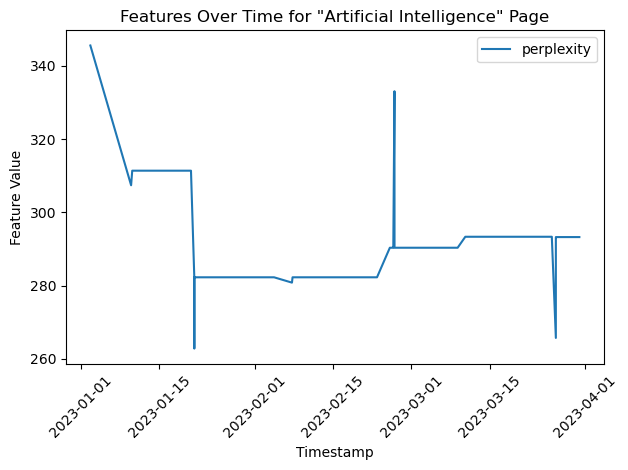

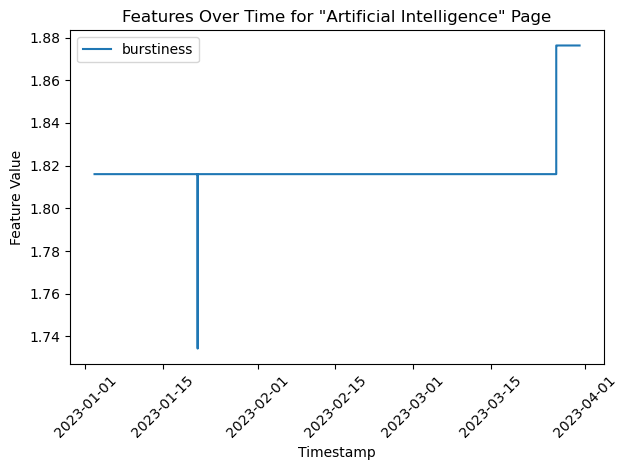

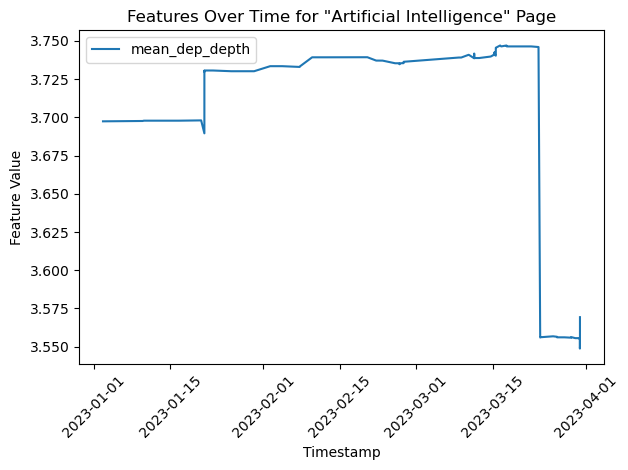

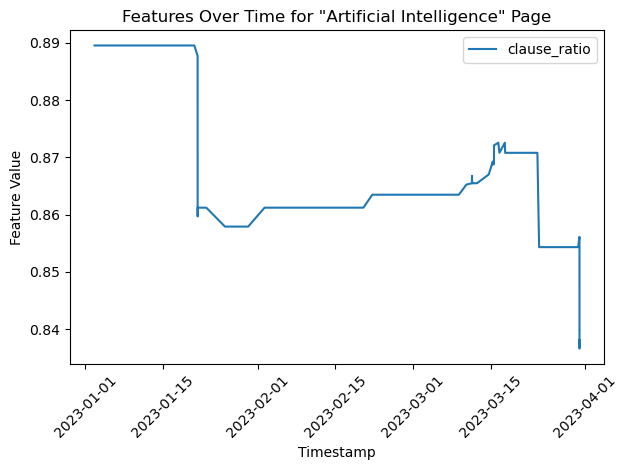

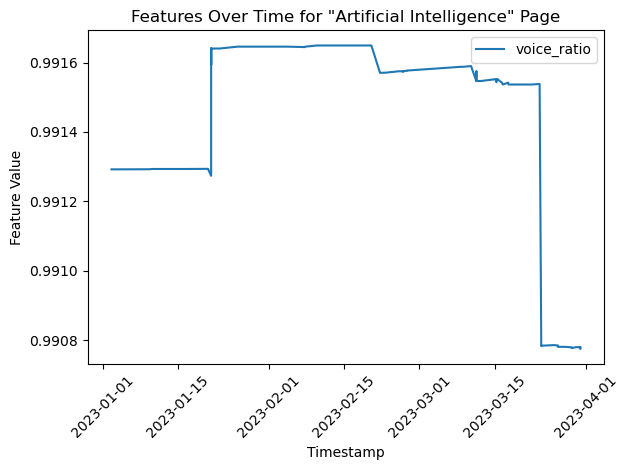

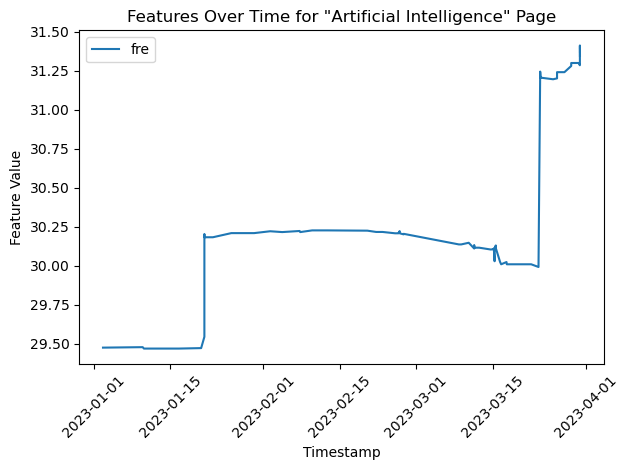

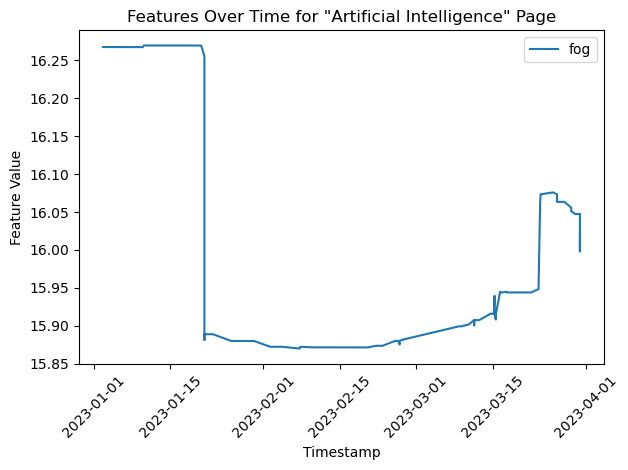

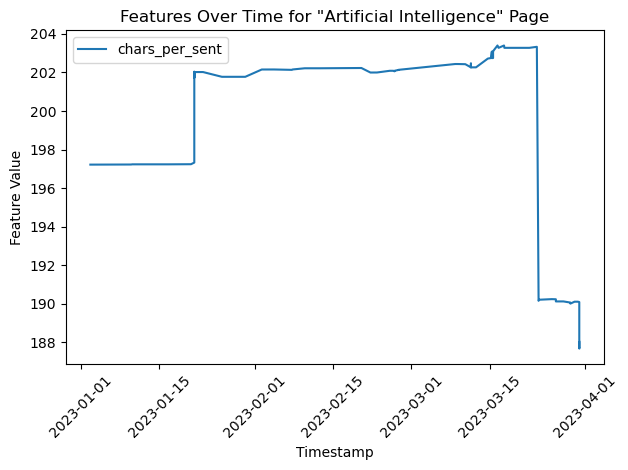

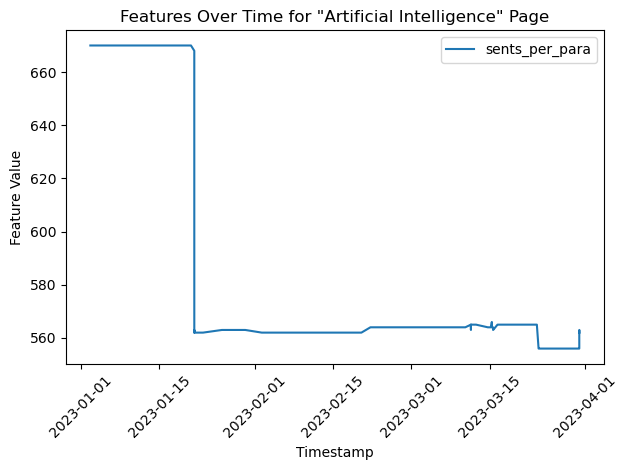

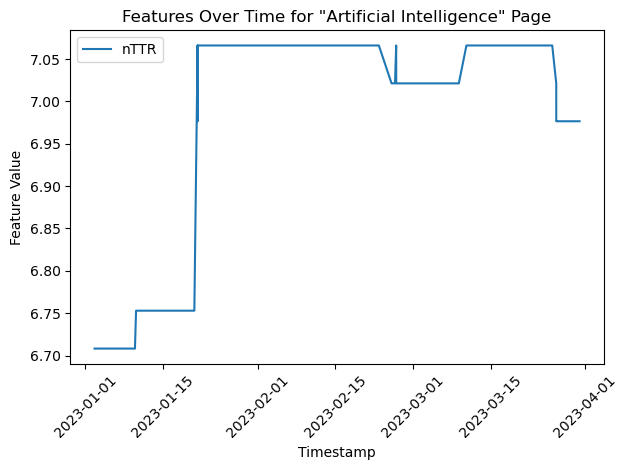

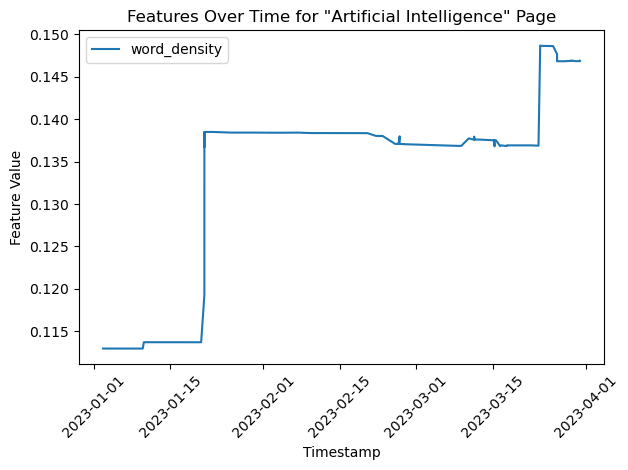

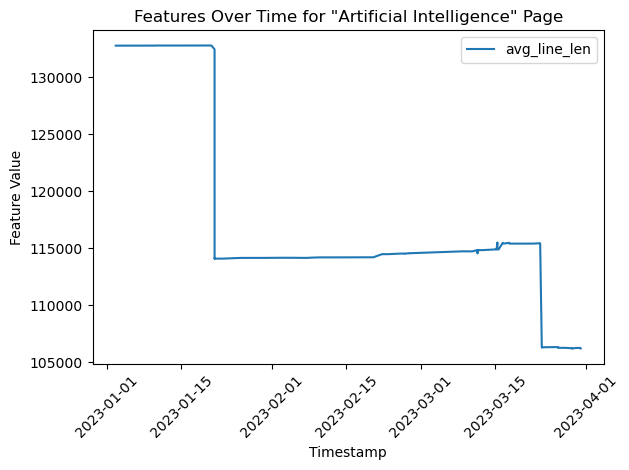

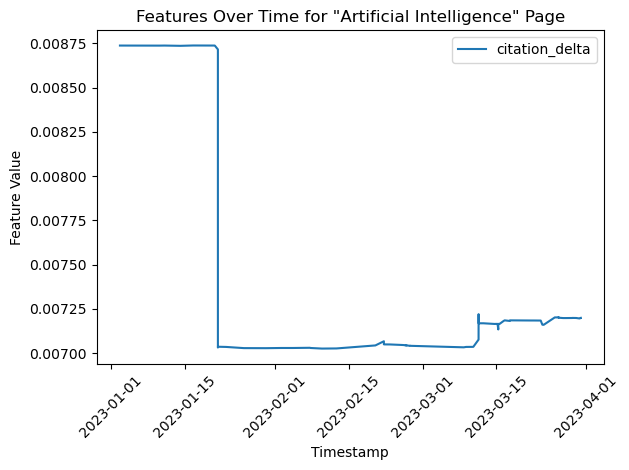

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file.csv' with your actual file path
df = pd.read_csv('tiny_revisions_features.csv')

# Plot all columns (features) except 'page_title', 'rev_id', 'timestamp', 'user', 'is_bot', rev_id for the Artificial Intelligence page against the timestamp
ai_df = df[df['page_title'] == 'Artificial intelligence'].copy()

# Convert timestamp to datetime
ai_df['timestamp'] = pd.to_datetime(ai_df['timestamp'])
# Set timestamp as index
ai_df.set_index('timestamp', inplace=True)
# Plotting
plt.figure(figsize=(14, 10))
for column in ai_df.columns:
    if column not in ['page_title', 'rev_id', 'user', 'is_bot']:
        plt.plot(ai_df.index, ai_df[column], label=column)
        plt.title('Features Over Time for "Artificial Intelligence" Page')
        plt.xlabel('Timestamp')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()